In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import PIL as pl
import os
import pandas as pd
import time
import random

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AvgPool2D, MaxPooling2D, Flatten, Dense, Dropout, RandomBrightness, RandomFlip
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

TypeError: Image data of dtype object cannot be converted to float

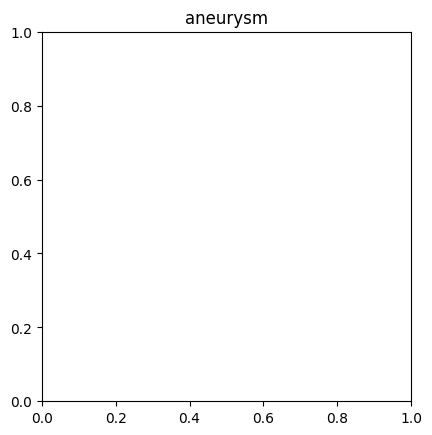

In [8]:
img = cv2.imread("files/aneurysm/10.jpg")
plt.title('aneurysm')
plt.imshow(img, label = 'aneurysm')
plt.show()

In [ ]:
img = cv2.imread("/kaggle/input/gssoc-ct-augumented-ds/files/cancer/20.jpg")
plt.title('cancer')
plt.imshow(img, label = 'cancer')
plt.show()

In [ ]:
img = cv2.imread("/kaggle/input/gssoc-ct-augumented-ds/files/tumor/10.jpg")
plt.title('Tumor')
plt.imshow(img, label = 'Tumor Case')
plt.show()


In [ ]:
def load_image(file_path):
    """
    Load an image from file.

    Args:
    - file_path: Path to the image file.

    Returns:
    - img: Loaded image as a numpy array.
    """
    img = cv2.imread(file_path)
    return img

def display_sample_images(image_paths, labels, num_samples=5):
    """
    Display sample images from the dataset.

    Args:
    - image_paths: List of paths to image files.
    - labels: List of corresponding labels for the images.
    - num_samples: Number of sample images to display (default: 5).
    """
    buff = 0
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(5):
        img_path = os.path.join('/kaggle/input/gssoc-ct-augumented-ds/files', image_paths[i+buff])
        img = cv2.imread(img_path)
        if img is not None:
            # print("Image Loaded Successfully.")
            # print("Image dtype:", img.dtype)
            axes[i].imshow(img)
            axes[i].set_title(labels[i+buff])
            axes[i].axis('off')
        else:
            print("Error: Unable to load image.")
        buff += 50
    plt.show()


def plot_class_distribution(labels):
    """
    Plot the distribution of classes in the dataset.

    Args:
    - labels: List of class labels.
    """
    class_counts = pd.Series(labels).value_counts()
    class_counts.plot(kind='bar', rot=0)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution')

    # Add counts over bars
    for i, count in enumerate(class_counts):
        plt.text(i, count + 0.1, str(count), ha='center')

    plt.show()

def visualize_image_statistics(images):
    """
    Visualize statistics of image data.

    Args:
    - images: List of image arrays.
    """
    image_shapes = [img.shape for img in images]
    image_means = [np.mean(img) for img in images]
    image_stds = [np.std(img) for img in images]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].hist(image_shapes)
    axes[0].set_title('Image Shapes')
    axes[0].set_xlabel('Shape')
    axes[0].set_ylabel('Frequency')

    axes[1].hist(image_means)
    axes[1].set_title('Image Pixel Mean')
    axes[1].set_xlabel('Mean')
    axes[1].set_ylabel('Frequency')

    axes[2].hist(image_stds)
    axes[2].set_title('Image Pixel Standard Deviation')
    axes[2].set_xlabel('Standard Deviation')
    axes[2].set_ylabel('Frequency')

    plt.show()

def perform_eda(dataset_folder):
    """
    Perform exploratory data analysis (EDA) on the image dataset.

    Args:
    - dataset_folder: Path to the dataset folder containing image files.
    """
    # Load dataset information from .csv file
    dataset_info = pd.read_csv(os.path.join(dataset_folder, 'ct-brains-augmented.csv'))

    # Display sample images
    display_sample_images(dataset_info['jpg'], dataset_info['type'])

    # Plot class distribution
    plot_class_distribution(dataset_info['type'])

    # Load images and visualize image statistics
    images = []
    # print(dataset_info['jpg'])
    for file_path in dataset_info['jpg']:
        img = load_image(os.path.join('/kaggle/input/gssoc-ct-augumented-ds/files', file_path))
        images.append(img)
    visualize_image_statistics(images)

# Example usage:
dataset_folder = r"/kaggle/input/gssoc-ct-augumented-ds/files"
perform_eda(dataset_folder)

In [ ]:
# Generate data paths with labels
def define_paths(dir):
    filepaths = []
    labels = []

    classes = os.listdir(dir)
    for class_name in classes:
        if os.path.isdir(os.path.join(dir, class_name)):
            class_path = os.path.join(dir, class_name)
            filelist = os.listdir(class_path)
            for file in filelist:
                fpath = os.path.join(class_path, file)
                if fpath.endswith('.jpg'):
                    filepaths.append(fpath)
                    labels.append(class_name)
    return filepaths, labels


# Concatenate data paths with labels into one dataframe
def define_df(files, classes):
    Fseries = pd.Series(files, name='filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis=1)

# Split data into train, validation, and test
def split_data(dir):
    files, classes = define_paths(dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, valid_df, test_df = train_valid_test_split(df, train_size=0.6, valid_size=0.05, test_size=0.35, shuffle=True, random_state=123, stratify=strat)
    return train_df, valid_df, test_df

# Custom train, validation, test split function
def train_valid_test_split(df, train_size, valid_size, test_size, shuffle=True, random_state=None, stratify=None):
    assert train_size + valid_size + test_size == 1.0, "The sum of train_size, valid_size, and test_size should be 1.0"


    if shuffle:
        df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)

    num_samples = len(df)
    train_end = int(train_size * num_samples)
    valid_end = int((train_size + valid_size) * num_samples)

    train_df = df[:train_end]
    valid_df = df[train_end:valid_end]
    test_df = df[valid_end:]

#     return train_df, test_df
    return train_df, valid_df, test_df


# Get Dataframes
data_dir = r"/kaggle/input/gssoc-ct-augumented-ds/files"
# train_df, test_df = split_data(data_dir)
train_df, valid_df, test_df = split_data(data_dir)

# Display the head of each dataframe
print("Train Data:")
print(train_df.head())
print("")
print(train_df.tail())
print("")

print("Validation Data:")
print(valid_df.head())
print("")
print(valid_df.tail())
print("")

print("Test Data:")
print(test_df.head())
print("")
print(test_df.tail())

In [ ]:
print(train_df.info())

In [ ]:
print(valid_df.info())


In [ ]:
print(test_df.info())

In [ ]:
def create_model_data (train_df, valid_df, test_df, batch_size):

    ''' This function takes train, validation, and test dataframe and fit them into image data generator, because model takes
         data from image data generator.
         Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                            color_mode= color, shuffle= True, batch_size= batch_size)
    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                                color_mode= color, shuffle= True, batch_size= batch_size)
    
    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                           color_mode= color, shuffle= False, batch_size= test_batch_size)

#     return train_gen, test_gen
    return train_gen, valid_gen, test_gen
Batch_size = 32
train_gen, valid_gen, test_gen = create_model_data(train_df, valid_df, test_df, Batch_size)

In [ ]:
def show_images(gen):

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator


    # calculate number of dispalyed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)

        # note
        index = np.argmax(labels[i])  # get image index

        class_name = classes[index]   # get class of image

        plt.title(class_name, color= 'blue', fontsize= 8)
        plt.axis('off')
    plt.show()

In [ ]:
# Display Image Samples
show_images(train_gen)

In [ ]:
show_images(test_gen)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, Reshape, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.regularizers import L1L2

tf.keras.backend.clear_session()

# Load the VGG16 model without the top (classification) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3), pooling = 'max')


# Freeze the pre-trained layers
# base_model.trainable = False

# Create a new model that includes the base_model
input_shape = (224, 224, 3)
vgg_model= tf.keras.Sequential([
#     tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape = (224,224, 3)),
#     tf.keras.layers.experimental.preprocessing.Resizing(224, 224),
    
    base_model,
    
    Dense(124, activation='relu', kernel_regularizer=L1L2(l1=0.001, l2=0.001)),
    BatchNormalization(),
    Dropout(0.45),
    
    Dense(64, activation='relu', kernel_regularizer=L1L2(l1=0.001, l2=0.001)),
    BatchNormalization(),
    Dropout(0.45),

    Dense(16, activation='relu', kernel_regularizer=L1L2(l1=0.001, l2=0.001)),
    BatchNormalization(),
    Dropout(0.45),

    Dense(3, activation='softmax')
])

# Compile the model
vgg_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(0.001),
    metrics=['accuracy', Precision(), Recall(), AUC()]
)
vgg_model.summary()

In [ ]:
batch_size = 32  # set batch size for training
epochs = 90     # number of all epochs in training
patience = 1 		 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3 	# number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9 	  # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor = 0.5 		    # factor to reduce lr by
ask_epoch = 5		    # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

# callbacks = [MyCallback(vgg_model, patience= patience,
#                         stop_patience= stop_patience, threshold= threshold, factor= factor,
#                         batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
history = vgg_model.fit(
    x=train_gen,
    epochs=epochs,
    verbose=2,
    callbacks=[early_stopping],
    validation_data=valid_gen,
    validation_steps=None,
    shuffle=True
)

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
# Visualize the model architecture
plot_model(vgg_model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    


    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
plot_training(history)

In [ ]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [ ]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = vgg_model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = vgg_model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = vgg_model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

In [ ]:
preds = vgg_model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools